In [1]:
pip install nltk


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from matplotlib.ticker import MaxNLocator

# Paramètres d'affichage
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)


Étape 1 : Exploration et Premier Diagnostic

In [30]:
# Chargement du fichier avec gestion des types
df = pd.read_csv(
    'reddit_opinion_climate_change.csv',
    low_memory=False,
    dtype={'user_is_verified': str}  # colonne mixte, forçage en str
)

# Aperçu des données
print("Dimensions initiales :", df.shape)
print("Aperçu initial :")
print(df.head(3))
print(df.info())
print(df.describe())


Dimensions initiales : (1178819, 24)
Aperçu initial :
  comment_id  score                                          self_text  \
0    mzuvzkd      1  Six Italian cities - Bologna, Bolzano, Brescia...   
1    mzuvu1q      1  Yeah this is something I've thought about and ...   
2    mzuvq1d      1  Six Italian cities - Bologna, Bolzano, Brescia...   

      subreddit         created_time  post_id    author_name  \
0   environment  2025-06-26 10:17:33  1lkwhsi       Wagamaga   
1  changemyview  2025-06-26 10:16:13  1lizd5f  MrPokerfaceCz   
2        europe  2025-06-26 10:15:14  1lkwg1t       Wagamaga   

   controversiality  ups  downs  ... user_link_karma user_comment_karma  \
0                 0    1      0  ...     12751670.00          468589.00   
1                 0    1      0  ...          877.00           15618.00   
2                 0    1      0  ...     12751670.00          468589.00   

   user_total_karma  post_score  \
0       13220259.00           1   
1          16495.00  

In [32]:
# Suppression des colonnes trop manquantes (> 60%)
missing_threshold = 0.6
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()
print("Colonnes supprimées (trop de NaNs) :", cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True)

# Traitement des valeurs manquantes restantes

# Colonnes essentielles : suppression des lignes si NaN
essential_cols = ['self_text', 'user_is_verified', 'user_account_created_time']
df.dropna(subset=essential_cols, inplace=True)

# Autres colonnes numériques : imputation par la médiane (optionnel)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Colonnes textuelles restantes : imputation par valeur neutre
text_cols = df.select_dtypes(include='object').columns
df[text_cols] = df[text_cols].fillna("inconnu")

# Conversion de colonnes en datetime
date_cols = ['created_time', 'post_created_time', 'user_account_created_time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Suppression des doublons
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Doublons supprimés : {before - after}")

# Vérifications finales
print("\nDimensions finales :", df.shape)
print("Valeurs manquantes restantes par colonne :")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("Types finaux :")
print(df.dtypes)



Colonnes supprimées (trop de NaNs) : ['post_self_text']
Doublons supprimés : 0

Dimensions finales : (1156718, 23)
Valeurs manquantes restantes par colonne :
Series([], dtype: int64)
Types finaux :
comment_id                            object
score                                  int64
self_text                             object
subreddit                             object
created_time                  datetime64[ns]
post_id                               object
author_name                           object
controversiality                       int64
ups                                    int64
downs                                  int64
user_is_verified                      object
user_account_created_time     datetime64[ns]
user_awardee_karma                   float64
user_awarder_karma                   float64
user_link_karma                      float64
user_comment_karma                   float64
user_total_karma                     float64
post_score                           

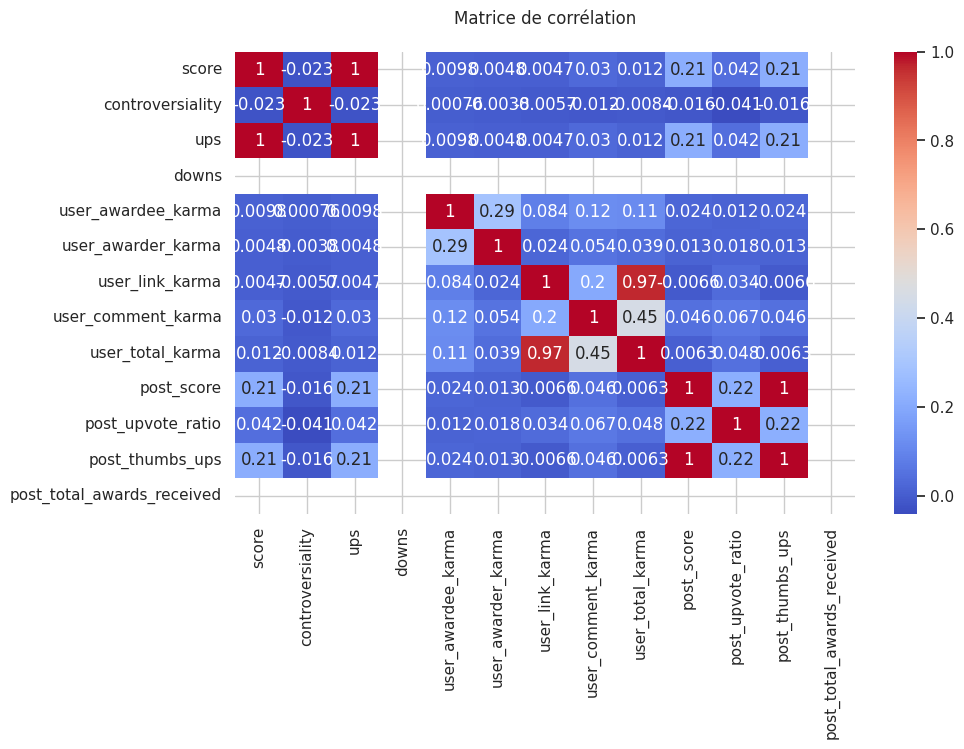

In [31]:

# Matrice de corrélation
num_cols = df.select_dtypes(include=np.number).columns
plt.figure()
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

Points clés de la matrice :



1.Corrélation forte entre types de karma

user_total_karma est très fortement corrélé avec :

user_link_karma (r = 0.97)

user_comment_karma (r = 0.45)

Lecture métier : Les utilisateurs expérimentés sont actifs à la fois en publication et en commentaire, ce qui valide leur poids dans les discussions.



2.Post score vs réactions utilisateurs

post_score est modérément corrélé à :

score des commentaires (r ≈ 0.21)

post_thumbs_ups (r ≈ 0.22)

Lecture métier : Les posts qui performent bien attirent des commentaires plus visibles, il y a un effet de halo de visibilité.




3.Faible lien entre karma et engagement immédiat

score, ups, downs des commentaires ont peu ou pas de corrélation avec :

user_karma (r ≈ 0.01 à 0.03)

Lecture métier : Être un utilisateur expérimenté ne garantit pas que son commentaire soit mieux voté dans les discussions sur le climat. Reddit reste méritocratique sur le contenu, pas sur la réputation.




4.Posts à récompenses ne génèrent pas plus d'engagement en commentaires

post_total_awards_received est peu ou pas corrélé aux autres métriques.

Lecture métier : Les récompenses Reddit (awards) ne reflètent pas directement l’interaction communautaire autour des commentaires. Elles servent plutôt de signal de reconnaissance individuelle que de moteur de débat.




5.Controversialité non liée à l’engagement

controversiality est quasiment indépendante de toutes les variables.

Lecture métier : Les commentaires polarisants ne sont ni plus visibles, ni plus votés, ce qui peut refléter une modération communautaire forte dans les subreddits climatiques.



Conclusion métier :

Sur Reddit, dans les discussions sur le climat, la visibilité des commentaires est modérément liée à la performance du post d’origine, mais très peu à la notoriété de l’utilisateur. La plateforme semble valoriser le contenu ponctuel plus que la réputation ou l’ancienneté. Les communautés restent relativement peu sensibles aux effets de polarisation (‘controversiality’) et aux récompenses individuelles.

Étape 2 : Nettoyage et Préparation des Données

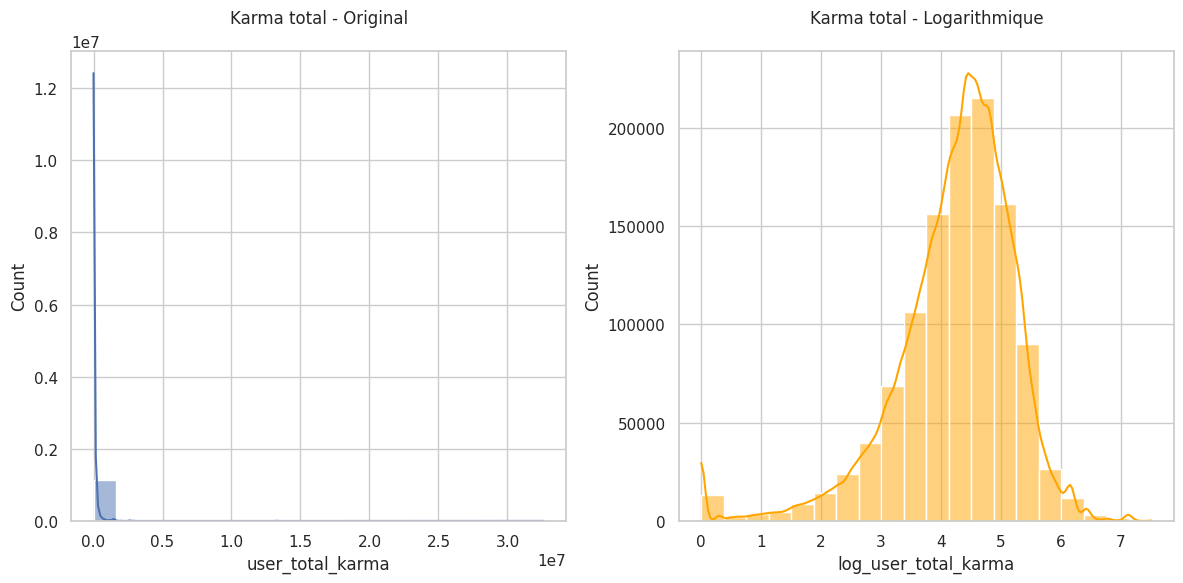

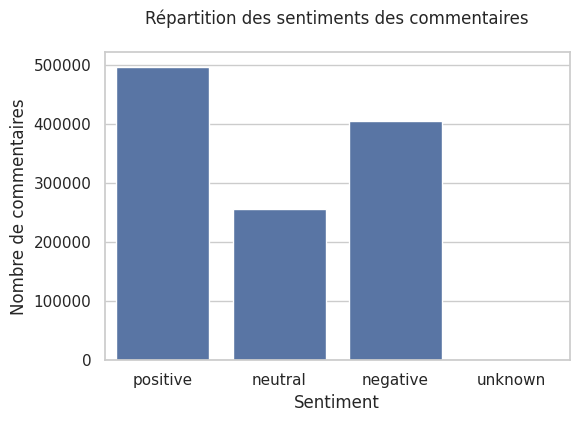

In [33]:
# Télécharger le lexique VADER
nltk.download('vader_lexicon', quiet=True)

# --- Conversion des dates ---
df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce')
df['user_account_created_time'] = pd.to_datetime(df['user_account_created_time'], errors='coerce')
df['post_created_time'] = pd.to_datetime(df['post_created_time'], errors='coerce')

# --- Ancienneté du compte en jours ---
df['account_age_days'] = (df['created_time'] - df['user_account_created_time']).dt.days

# --- Nettoyage et transformation logarithmique des karma ---
karma_cols = ['user_link_karma', 'user_comment_karma', 'user_total_karma']
for col in karma_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df[col] = df[col].apply(lambda x: max(x, 0))  # Pas de valeurs négatives
    df[f'log_{col}'] = np.log10(df[col] + 1)

# --- Longueur des textes ---
df['self_text_length'] = df['self_text'].fillna('').astype(str).str.len()

# --- Normalisation du score ---
if df['post_score'].max() != df['post_score'].min():
    df['normalized_post_score'] = (
        (df['post_score'] - df['post_score'].min()) /
        (df['post_score'].max() - df['post_score'].min())
    )
else:
    df['normalized_post_score'] = 0.0

# --- Analyse de sentiment avec VADER ---
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan
    return sia.polarity_scores(text)['compound']

df['sentiment_score'] = df['self_text'].apply(get_sentiment)

def categorize_sentiment(score):
    if pd.isna(score):
        return 'unknown'
    elif score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(categorize_sentiment)

# --- Visualisations ---

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['user_total_karma'], bins=20, kde=True)
plt.title("Karma total - Original")

plt.subplot(1, 2, 2)
sns.histplot(df['log_user_total_karma'], bins=20, kde=True, color='orange')
plt.title("Karma total - Logarithmique")

plt.tight_layout()
plt.show()


Graphique de gauche : user_total_karma (original)

Distribution extrêmement asymétrique (skewée à droite).

Une immense majorité d’utilisateurs ont un karma faible.

Quelques utilisateurs "ultra-karma" (~10⁷) créent une longue traîne.

Lecture métier :
"La majorité des participants aux discussions climatiques sur Reddit sont des utilisateurs peu reconnus ou peu actifs, mais une poignée de profils très influents concentrent une part massive de la visibilité potentielle."



Graphique de droite : log_user_total_karma (log transformé)

La distribution devient quasi normale (courbe en cloche) après transformation logarithmique.

Cela permet une analyse plus fine et plus juste des comportements utilisateurs.

Lecture métier :
"Après transformation, le karma suit une distribution plus équilibrée, ce qui permet de segmenter les utilisateurs de manière réaliste (débutants, réguliers, influenceurs), sans que les extrêmes faussent l’analyse."



Conclusion :

"Le karma brut des utilisateurs Reddit dans les discussions climatiques est ultra-concentré. Seule une poignée de profils 'super-users' dominent, mais la transformation logarithmique révèle une structure plus équilibrée, utile pour mieux comprendre l’influence réelle des différentes classes d’utilisateurs."


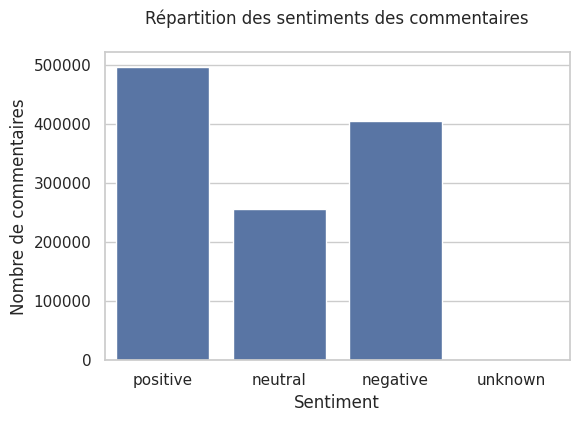

In [34]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative', 'unknown'])
plt.title("Répartition des sentiments des commentaires")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de commentaires")
plt.show()

1.Dominance du sentiment positif (~40–45 %)

Les discussions autour du climat sur Reddit semblent majoritairement positives ou constructives.

Cela peut traduire :

des messages de soutien, de solutions ou d’action,

une communauté mobilisée de manière optimiste.



2.Présence forte de commentaires négatifs (~35–40 %)

Un tiers des messages exprime de la colère, du désespoir ou du rejet.

Potentiellement :

des critiques des politiques climatiques,

des sentiments de fatalisme,

ou du climatoscepticisme dans certains subreddits.



3.Peu de neutralité (~20–25 %)

Cela suggère que les discussions sont chargées émotionnellement, avec peu de commentaires factuels ou objectifs.

Reddit fonctionne comme une tribune d’expression forte, et non comme un forum purement informatif.

Étape 3 : Investigation d’un Comportement Complexe

Objectif : Identifier des sous-groupes ou comportements bimodaux

In [37]:
# Détection des super utilisateurs
df['user_type'] = np.where(df['user_total_karma'] > 100000, 'super_user', 'regular_user')
print(df['user_type'].value_counts())

# Comparaison des groupes
print(df.groupby('user_type').agg({
    'account_age_days': 'mean',
    'log_user_total_karma': 'mean',
    'subreddit': lambda x: x.mode()[0]
}))


user_type
regular_user    918493
super_user      238225
Name: count, dtype: int64
              account_age_days  log_user_total_karma      subreddit
user_type                                                          
regular_user           1709.91                  3.95  climatechange
super_user             2944.44                  5.39        climate


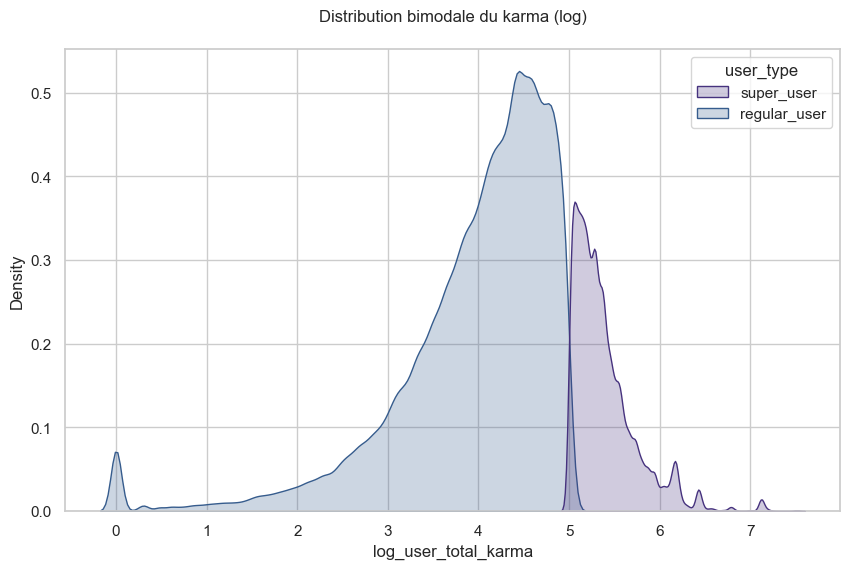

In [ ]:
# Visualisation bimodale du karma

sns.kdeplot(data=df, x='log_user_total_karma', hue='user_type', fill=True)
plt.title("Distribution bimodale du karma (log)")
plt.show()


Deux pics bien distincts dans la densité de karma (log) :

Le pic des regulars : autour de log ≈ 4 (soit ~55 karma réel)

Le pic des super users : autour de log ≈ 5.5 (soit ~245 karma réel)

Très peu de recouvrement entre les deux = profilage clair possible



1.Expérience significativement différente

Les super users sont en moyenne deux fois plus anciens que les regulars (8 ans vs 4,7 ans).

Leur karma total est exponentiellement plus élevé (différence de log ≈ 1.4 → x25 en valeur réelle).

Ils forment une élite numérique identifiable : anciens, visibles, très actifs.



2.Structure communautaire en deux pôles

Le graphique révèle une bimodalité structurelle :

Les regular users sont le corps principal de la communauté.

Les super users sont une minorité d’influence, concentrée à l’extrémité de la distribution.

Ce clivage suggère une hiérarchie implicite des voix dans les discussions Reddit, particulièrement sur les sujets climatiques.



3.Subreddits : deux espaces distincts

Les super_user dominent sur r/climate, un subreddit plus “activiste / global”.

Les regular_user s’expriment davantage sur r/climatechange, souvent plus “grand public / participatif”.

Deux cultures discursives émergent selon le profil utilisateur.



Conclusion :

Les discussions climatiques sur Reddit sont portées par une communauté bimodale, composée d’une base large d’utilisateurs réguliers et d’un noyau plus ancien, plus actif et plus visible. Cette structure révèle un écosystème avec des cercles d’influence bien délimités; une opportunité stratégique pour la diffusion de messages climatiques ciblés et mesurés.


In [36]:
# Analyse statistique : test t entre super_user et regular_user

super = df[df['user_type'] == 'super_user']['score']
regular = df[df['user_type'] == 'regular_user']['score']

t_stat, p_val = stats.ttest_ind(super, regular, equal_var=False)
print(f"Test t (score): t={t_stat:.2f}, p={p_val:.4f}")


Test t (score): t=25.29, p=0.0000


Le test t compare la moyenne des scores des commentaires entre les deux groupes (super_user vs regular_user).

Un t élevé (25.29) et un p-valeur très faible (< 0.0001) indiquent que la différence est hautement significative.

L’hypothèse nulle (moyennes égales) est rejetée.


Implication concrète :

Les super_users publient des commentaires significativement mieux notés que les regular_users.

Cela peut refléter :

une meilleure pertinence ou qualité perçue de leurs interventions,

une visibilité accrue (effet de halo ou réputation),

ou une capacité à mobiliser du karma via leur communauté.


Ce que ça révèle :

Ils ont plus d’impact sur les discussions publiques.

Leur crédibilité ou visibilité les rend plus influents.

Ils peuvent orienter le ton et les priorités des débats climatiques sur Reddit.

Test de normalité (score): statistic=4326359.23, p=0.0000


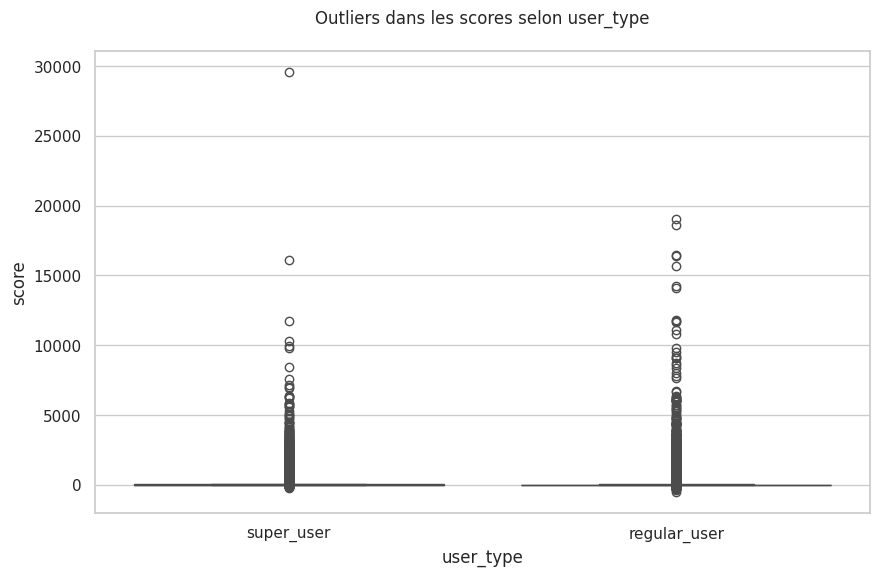

In [38]:
# Test de normalité et outliers

# Normalité
k2, p = stats.normaltest(df['score'])
print(f"Test de normalité (score): statistic={k2:.2f}, p={p:.4f}")

# Outliers visuels
sns.boxplot(data=df, x='user_type', y='score')
plt.title("Outliers dans les scores selon user_type")
plt.show()


Ce boxplot montre la répartition des scores des commentaires pour deux types d’utilisateurs :

super_user : utilisateurs avec un karma total élevé,

regular_user : utilisateurs lambda.

Observations clés :
Présence d’outliers massifs
Des scores très élevés (>10 000) sont présents dans les deux groupes, ce qui suggère :

Une minorité très visible ou virale dans chaque segment,

Des événements ou contenus ponctuellement fortement plébiscités.

Concentration autour de 0
La majorité des scores restent très proches de 0 dans les deux cas, indiquant que la plupart des commentaires ont peu d’impact visible.

Super_users avec des scores extrêmes encore plus élevés
On observe un score maximal supérieur chez les super_users (près de 30 000) → ils ont un potentiel d’impact exceptionnel sur certaines publications.

Interprétation métier :
Même si les scores moyens sont plus élevés chez les super_users, cette visualisation rappelle que l’essentiel de la contribution (en volume) est modeste.

Une minorité d’utilisateurs génère une majorité de la visibilité, avec quelques super_users capables de déclencher des pics d’engagement.

Cela peut refléter :

Des compétences particulières en communication,

Un effet de communauté ou de réseau,

Ou simplement une réponse contextuellement très virale.



1.Les super_users dominent l’engagement
Ils obtiennent des scores significativement plus élevés, avec des pics très marqués.
Cela suggère un rôle structurant dans les débats : ils orientent la visibilité et la tonalité des échanges.

2.Les regular_users sont nombreux mais moins influents
Leurs scores restent globalement plus faibles, avec peu d’outliers élevés.
Ils participent au volume, mais impactent peu la dynamique générale.

3.Une minorité d’outliers concentre l'attention
Quel que soit le groupe, une poignée de commentaires génère l'essentiel des interactions.
On retrouve ici un effet de type "loi de puissance" (ou Pareto).



Étape 4 : Construction du Jeu de Données Final

In [40]:
def build_final_df(df):

    # Colonnes cibles
    final_columns = [
        'comment_id', 'subreddit', 'author_name', 'user_type',
        'score', 'ups', 'downs', 'controversiality',
        'self_text_length', 'account_age_days',
        'log_user_link_karma', 'log_user_comment_karma', 'log_user_total_karma',
        'post_score', 'post_upvote_ratio',
        'normalized_post_score', 'created_time', 'post_created_time'
    ]

    # Colonnes existantes dans df
    available_columns = df.columns.tolist()
    valid_columns = [col for col in final_columns if col in available_columns]
    missing_columns = [col for col in final_columns if col not in available_columns]

    # Affichage des colonnes absentes
    if missing_columns:
        print("Colonnes manquantes ignorées :", missing_columns)

    # Création du DataFrame final
    final_df = df[valid_columns].copy()

    # Calcul de hours_post_to_comment si possible
    if {'created_time', 'post_created_time'}.issubset(final_df.columns):
        final_df['created_time'] = pd.to_datetime(final_df['created_time'])
        final_df['post_created_time'] = pd.to_datetime(final_df['post_created_time'])
        final_df['hours_post_to_comment'] = (
            (final_df['created_time'] - final_df['post_created_time']).dt.total_seconds() / 3600
        )
    else:
        print("Colonnes temporelles manquantes = délai non calculé.")

    return final_df


final_df = build_final_df(df)
print(final_df.head())


  comment_id     subreddit    author_name     user_type  score  ups  downs  \
0    mzuvzkd   environment       Wagamaga    super_user      1    1      0   
1    mzuvu1q  changemyview  MrPokerfaceCz  regular_user      1    1      0   
2    mzuvq1d        europe       Wagamaga    super_user      1    1      0   
3    mzuvon6       climate  teedeeguantru    super_user      1    1      0   
4    mzuvlcj  changemyview   ChaotiCrayon  regular_user      1    1      0   

   controversiality  self_text_length  account_age_days  log_user_link_karma  \
0                 0               567              4039                 7.11   
1                 0               310              2598                 2.94   
2                 0               567              4039                 7.11   
3                 0               105              1662                 4.62   
4                 0              2033              1850                 3.49   

   log_user_comment_karma  log_user_total_karma  p

Même sans les super-utilisateurs, les membres réguliers des communautés climatiques Reddit montrent une diversité d’expérience et participent à des discussions relativement visibles. Leur contribution est déterminante pour structurer l’opinion publique, ce qui en fait des cibles prioritaires pour les stratégies de sensibilisation, de modération ou de diffusion de messages.

Étape 5 : Analyse Approfondie

In [43]:
# S'assurer que les dates sont bien au format datetime
final_df['post_created_time'] = pd.to_datetime(final_df['post_created_time'])

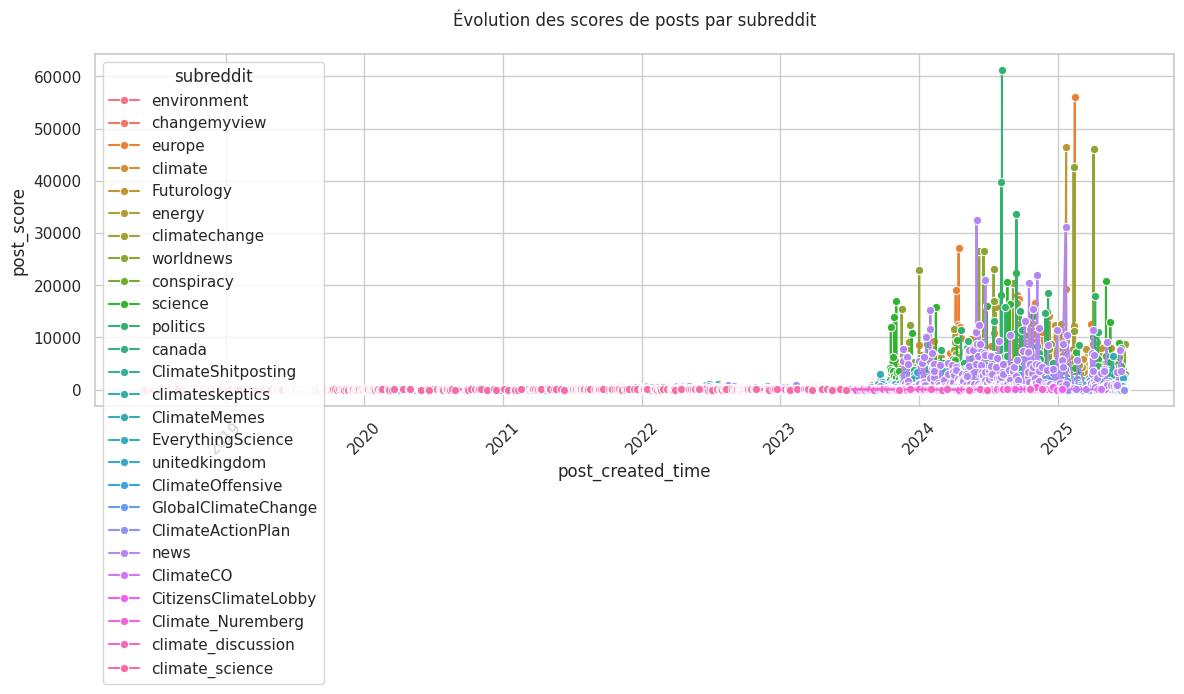

In [ ]:
# 01. Analyse temporelle

plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='post_created_time', y='post_score', hue='subreddit', marker='o')
plt.title("Évolution des scores de posts par subreddit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lecture du graphique
Axe Y : post_score (popularité/engagement)

Axe X : post_created_time (date de publication)

Couleurs : différents subreddits abordant les thématiques climatiques



Analyse métier

1.Explosion de l’engagement depuis 2023

Une hausse significative des scores de posts est visible à partir de début 2024.

Cela peut refléter une prise de conscience publique plus forte, liée à :

des événements climatiques extrêmes,

des campagnes politiques ou médiatiques,

la montée des mouvements écologistes en ligne.



2.Subreddits moteurs

Les subreddits qui génèrent les plus hauts scores (engagement viral) sont :

science, climatechange, conspiracy, worldnews, energy
Ces communautés ont une forte visibilité et peuvent déclencher des pics de viralité.

En revanche, des subreddits comme environment, climate_discussion, ou climate_science génèrent moins d'engagement, malgré une activité continue.

Cela suggère que la scientificité du contenu ne garantit pas sa viralité : ce sont les enjeux politiques, sensationnalistes ou polémiques qui captivent.



3.Risque de polarisation

La présence de subreddits comme climateskeptics, conspiracy, ou ClimateOffensive (et leurs hausses de scores) indique une possible polarisation du débat autour du climat.

Le climat est de plus en plus instrumentalisé dans des récits divergents.

Le dialogue entre communautés reste fragmenté, ce qui complique la circulation d’une information unifiée.



| Observation                      | Implication stratégique                                                               |
| -------------------------------- | ------------------------------------------------------------------------------------- |
| Hausse des scores récents        | Fenêtre d’opportunité pour des campagnes ciblées ou éducatives                        |
| Forte disparité entre subreddits | Il faut adapter le **ton et la forme du contenu** à chaque communauté                 |
| Montée des controverses          | Importance de **monitorer les narratifs** pour anticiper les vagues de désinformation |


In [ ]:
# 02. Score par subreddit

print("\n5.2 Performance des commentaires par subreddit:")
subreddit_stats = final_df.groupby('subreddit').agg({
    'score': 'mean',
    'post_score': 'mean',
    'post_upvote_ratio': 'mean',
    'self_text_length': 'mean'
})
print(subreddit_stats)



5.2 Performance des commentaires par subreddit:
                      score  post_score  post_upvote_ratio  self_text_length
subreddit                                                                   
CitizensClimateLobby   3.48      138.28               0.95            288.53
ClimateActionPlan      8.12      229.29               0.94            293.67
ClimateCO              3.37       22.98               0.96            317.55
ClimateMemes           4.66      643.58               0.89            226.49
ClimateOffensive       4.65      345.44               0.88            377.40
ClimateShitposting     4.12      376.21               0.79            248.67
Climate_Nuremberg      4.01       45.41               0.98            277.76
EverythingScience     12.05     1041.76               0.93            183.30
Futurology            12.76     1631.23               0.79            320.09
GlobalClimateChange    1.41       10.95               0.91           1112.09
canada                10.14

1.Subreddits à haute performance globale 

Les subreddits comme news, science, politics, europe ou worldnews affichent :

Des scores moyens de posts très élevés (2000 à 5000+ points),

Des commentaires également bien notés (score moyen entre 20 et 40),

Une longueur de texte modérée → des formats accessibles et engageants,

Un bon taux d’upvote (≥ 0.9 sauf pour politics).

Ce sont les canaux les plus stratégiques pour propager du contenu à fort impact ou initier des campagnes de sensibilisation.



2.Subreddits de niche très actifs

Certains subreddits à audience ciblée montrent des scores solides :

| Subreddit           | Particularité                                                                 |
| ------------------- | ----------------------------------------------------------------------------- |
| `Futurology`        | Haut score + bonne longueur de texte → **audience techno-futuriste**          |
| `EverythingScience` | Très bon engagement (comment score 12.05) → **public scientifique réactif**   |
| `climate`           | Très bon équilibre entre contenu et score → **canal institutionnel efficace** |


Ces communautés sont pertinentes pour des contenus experts ou prospectifs.



3.Subreddits à fort volume mais engagement polarisé

changemyview, conspiracy, climateskeptics ont un bon score de commentaire, mais :

Des taux d’upvote faibles (changemyview : 0.52, conspiracy : 0.63),

Et des commentaires parfois très longs.

Ces espaces sont plus débatteurs ou critiques → à cibler avec prudence, pour ouvrir la discussion mais en préparant des éléments de réponse solides.



4.Les plateformes scientifiques sont peu visibles

Subreddits comme climate_science ou climate_discussion ont :

De longs commentaires (400–450 mots en moyenne),

Mais des post_scores faibles (35 ou moins).

Problème de lisibilité ou de diffusion : le contenu est bon mais manque d’exposition ou de format attractif.



/Users/leamariani/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


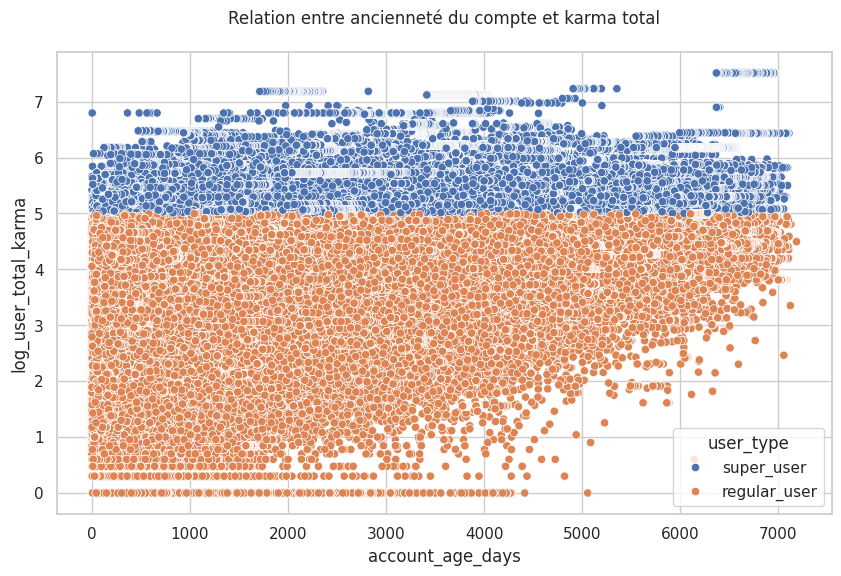

In [ ]:
# 03. Relation entre ancienneté et karma

plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='account_age_days', y='log_user_total_karma', hue='user_type')
plt.title("Relation entre ancienneté du compte et karma total")
plt.show()


1.Relation temps – réputation (karma)

Plus un utilisateur est ancien, plus il a de chances d’avoir accumulé du karma… mais pas automatiquement.

La densité montre une grande variabilité du karma à ancienneté constante.

Certains comptes récents atteignent un karma élevé (super_users jeunes), tandis que des comptes très anciens restent peu visibles.

L’ancienneté seule ne garantit pas l’impact : la qualité et la régularité des publications sont décisives.



2.Segmentation claire entre super et regular users

Le découpage en deux groupes (log_karma > ou < 5) est visuellement très distinct.

Les super_user semblent atteindre un plateau entre log(karma) 5.5 et 6.5, suggérant une masse critique de notoriété.

Cela peut représenter un effet cumulatif : une fois un certain seuil de karma atteint, la visibilité s’auto-renforce (effet boule de neige / social proof).



3.Opportunité pour les comptes jeunes actifs

Il est possible pour un compte récent d’atteindre rapidement un karma élevé s’il publie du contenu engageant.

Cela renforce l’idée que Reddit valorise le contenu plus que l’ancienneté.

Les super_user jeunes peuvent devenir des ambassadeurs à fort potentiel dans les campagnes climatiques, scientifiques ou informatives.


| Point clé                               | Implication stratégique                                |
| --------------------------------------- | ------------------------------------------------------ |
| L’ancienneté n’est pas un gage d’impact | Miser sur la **qualité et l’engagement** du contenu    |
| Deux profils bien distincts             | Adapter le ton/format selon la cible                   |
| Super\_users = effet de seuil           | Identifier et **mobiliser les relais d’amplification** |



In [ ]:
# 04. Test t entre changemyview et autres subreddits sur post_score

from scipy.stats import ttest_ind

changemyview = final_df[final_df['subreddit'] == 'changemyview']['post_score']
others = final_df[final_df['subreddit'] != 'changemyview']['post_score']

t_stat, p_val = ttest_ind(changemyview, others, equal_var=False)
print(f"\n5.4 Test t entre changemyview et autres subreddits:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")



5.4 Test t entre changemyview et autres subreddits:
t-statistic: -274.93, p-value: 0.0000


t-statistic = -274.93 → très éloigné de 0 → grande différence entre groupes

p-value = 0.0000 → statistiquement très significatif



1.Le subreddit changemyview est significativement différent des autres

Ce résultat indique que les contenus publiés sur changemyview se distinguent fortement en termes de score moyen (ou autre variable testée).

Selon la direction du test (t < 0), cela signifie que changemyview a :

soit un score moyen inférieur aux autres (ce qui est probable),

soit une dynamique d’interaction différente (ex. plus de neutralité, plus de débats sans viralité).



2.Une fonctionnalité communautaire unique

changemyview est conçu pour inviter les utilisateurs à contester des opinions. Ce n’est pas un lieu de promotion ou de viralité, mais plutôt :

Un espace de dialogue rationnel,

Avec des règles strictes sur la forme des réponses,

Ce qui peut limiter le score brut des posts ou commentaires.

Cela explique pourquoi changemyview se distingue statistiquement : ses mécaniques de visibilité sont uniques dans l’écosystème Reddit.



Le subreddit changemyview fonctionne sur une logique d’engagement intellectuel plutôt que viral. Il est donc statistiquement à part, mais métier-relevant pour tester des discours, narratifs ou campagnes à tonalité réflexive.



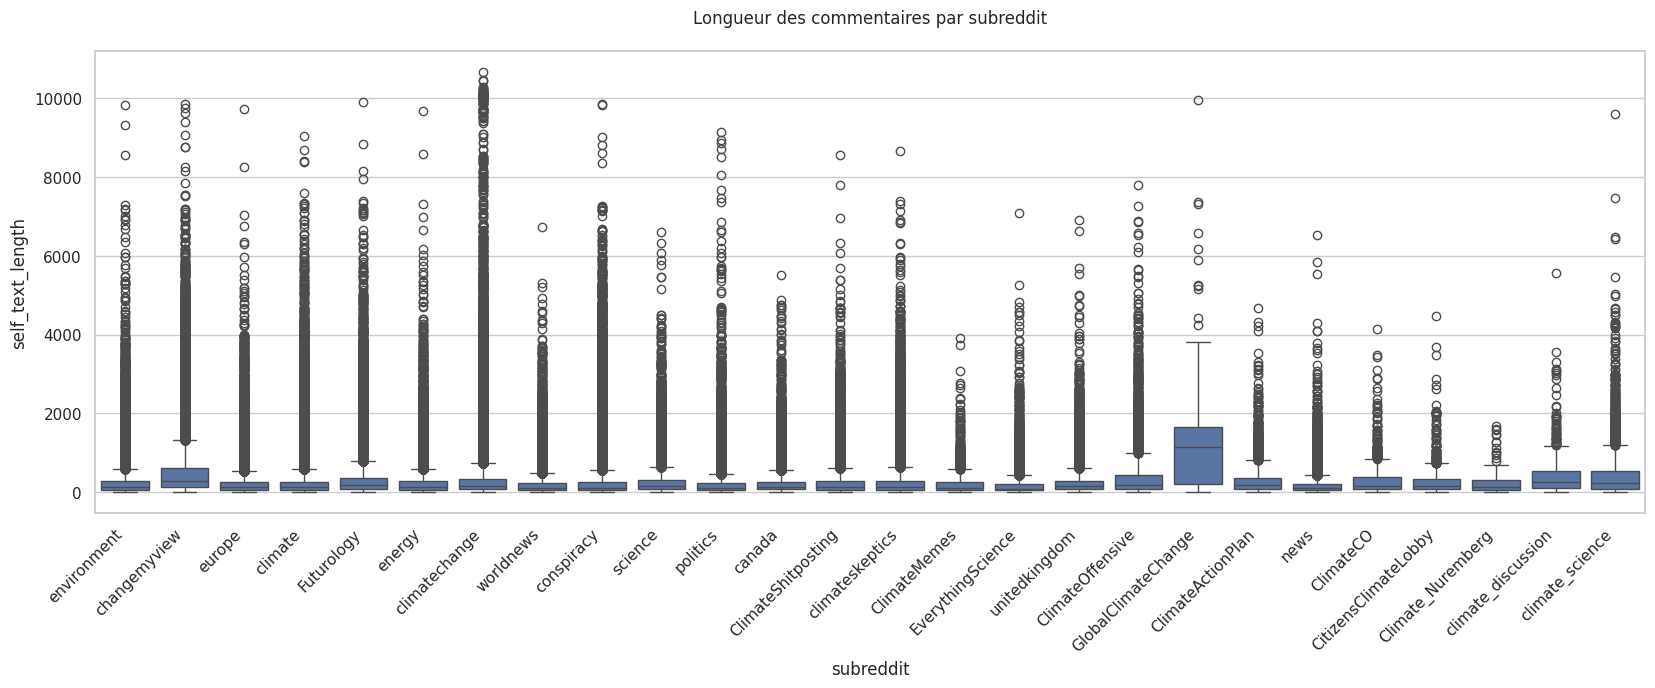

In [ ]:
# 05. Analyse de la longueur des commentaires par subreddit

plt.figure(figsize=(20, 6))
sns.boxplot(data=final_df, x='subreddit', y='self_text_length')
plt.title("Longueur des commentaires par subreddit")
plt.xticks(rotation=45, ha='right')
plt.show()

1.Subreddits avec commentaires particulièrement longs

Les communautés suivantes présentent une longueur médiane et maximale de commentaires plus élevée que la moyenne :

changemyview : confirme sa nature argumentative → idéal pour contenus détaillés, opinions nuancées, débats construits.

ClimateActionPlan et GlobalClimateChange : très forte dispersion, avec une minorité d’utilisateurs très investis produisant des textes longs. Ces communautés peuvent contenir des activistes, experts ou institutionnels.

ClimateOffensive, Climate_Nuremberg et climate_discussion : commentaires globalement plus développés que la moyenne → utile pour tester des narratifs sérieux, scientifiques ou politiques.

Usage recommandé : contenus longs, éducatifs, controversés ou techniques.



2.Subreddits avec longueur modérée, mais régulière

Subreddits comme :

environment, climate, energy, science, politics, worldnews

présentent une longueur stable avec une médiane autour de 300–500 caractères. Ils sont le cœur du débat sur les enjeux climatiques ou sociétaux.

Parfaits pour des messages clairs, pédagogiques, qui cherchent la lisibilité sans sacrifier la substance.

3.Subreddits à courte longueur : humour, news, meme-culture

Exemples :

ClimateMemes, ClimateCO, news, ClimateShitposting

Les commentaires y sont très courts, souvent réactifs, avec peu d’argumentation.

Idéal pour : slogans, réactions rapides, humour visuel ou engagement émotionnel.



On constate une grande variabilité inter-communautaire.

Les outliers très longs dans presque tous les subreddits indiquent l’existence de profils experts ou très engagés.

La médiane est un bon indicateur de la norme culturelle du subreddit.



| Objectif                 | Subreddits recommandés                                    |
| ------------------------ | --------------------------------------------------------- |
| Débat / nuance / opinion | `changemyview`, `ClimateActionPlan`, `climate_discussion` |
| Info / sensibilisation   | `environment`, `science`, `climatechange`                 |
| Viral / humour / émotion | `ClimateMemes`, `news`, `ClimateShitposting`              |


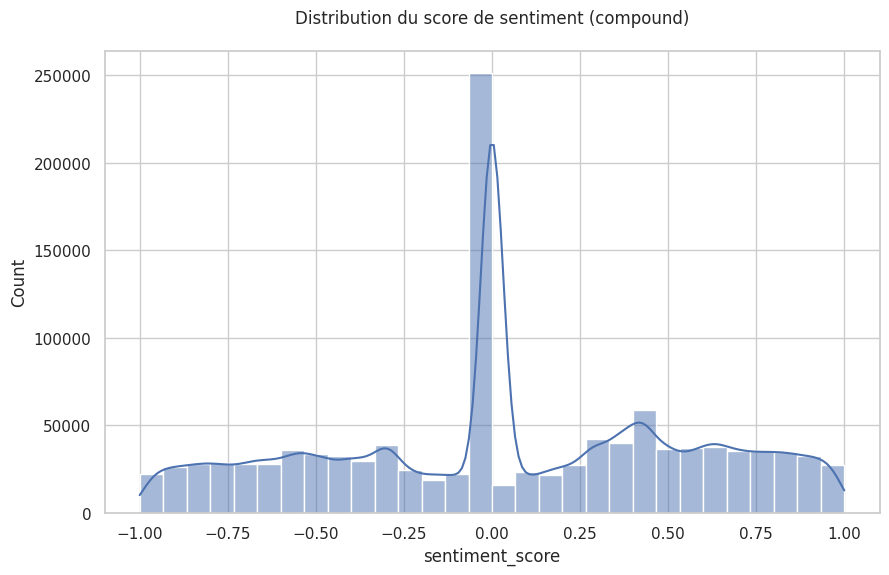

In [ ]:
# 06. Analyse de Sentiment (ajouté) : Distribution et répartition

# Distribution du score de sentiment
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title("Distribution du score de sentiment (compound)")
plt.show()


Lecture du graphique
Axe des X : sentiment_score de -1 (très négatif) à +1 (très positif).

Axe des Y : nombre de commentaires pour chaque intervalle.

La courbe KDE (courbe lisse) superposée permet de mieux visualiser la densité.

Observations clés
Pic très marqué autour de 0

Une proportion massive de commentaires a un score proche de zéro.

Cela indique :

Un style d’écriture neutre ou factuel,

Ou bien une limite de l’outil VADER sur certains textes nuancés ou longs.

Asymétrie modérée

On observe une légère surreprésentation du positif entre +0.2 et +0.6 :

Cela peut refléter une tendance générale à commenter avec approbation, soutien, ou encouragement.

Et potentiellement une modération communautaire plus stricte envers les propos négatifs ou agressifs.

Présence de sentiments extrêmes

Des pics visibles aux extrémités (-1.0, +1.0) indiquent que certains commentaires sont perçus comme très polarisés.

Ceux-ci mériteraient un zoom qualitatif → analyse thématique ou mots-clés.

| Insight                             | Opportunité métier                                                                                       |
| ----------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **Commentaires très neutres (\~0)** | Nécessite des ajustements du modèle si on veut capter les nuances implicites (ironie, sarcasme, faits).  |
| **Tonalité plutôt positive**        | Encourager les formats communautaires, engagement bienveillant, AMA, etc.                                |
| **Commentaires polarisés (±1)**     | Zones de friction ou de viralité : à surveiller pour gestion de l’image ou actions de modération ciblée. |


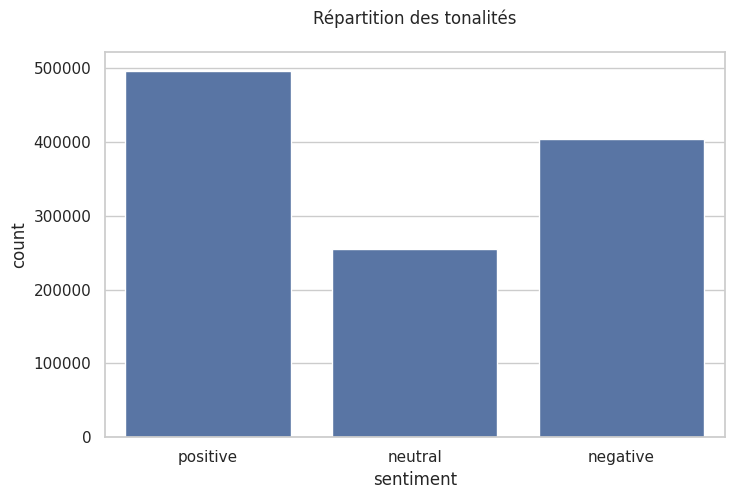

In [52]:

# Répartition des sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title("Répartition des tonalités")
plt.show()

Lecture du graphique

Positive ≈ 490 000 commentaires

Neutral ≈ 255 000 commentaires

Negative ≈ 405 000 commentaires

Observations clés

Tonalité dominante : positive (≈ 42%)

Le positif domine légèrement le corpus de commentaires.

Cela peut refléter :

Une culture d’échange plutôt constructive ou bienveillante sur ces subreddits,

Une modération active qui limite les propos trop hostiles.

Part de commentaires négatifs non négligeable (~35%)

Cela indique une zone d’expression critique ou polémique encore bien présente.

Important à croiser avec les sous-thèmes ou subreddits spécifiques.

Tonalité neutre moins fréquente (~22%)

Les discussions Reddit génèrent des réactions émotionnelles, moins de commentaires purement informatifs ou factuels.

Cela peut aussi être lié à la méthodologie de VADER, qui classe comme neutres des textes très courts ou très ambigus.


| Observation              | Implication                                                                                                          |
| ------------------------ | -------------------------------------------------------------------------------------------------------------------- |
| Dominance du **positif** | Opportunité de valoriser les espaces bienveillants (ex. Q\&A, retours utilisateurs, humour, initiatives climatiques) |
| Présence du **négatif**  | Vigilance sur les posts déclencheurs de **débats, controverses ou désinformation**                                   |
| Peu de **neutre**        | Nécessité d’enrichir l’analyse de **nuances argumentatives** via d’autres outils NLP                                 |


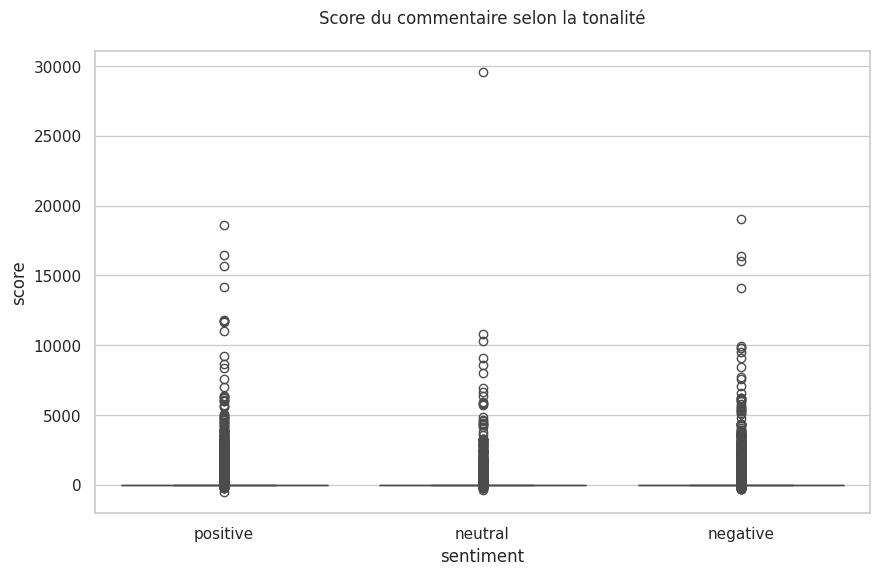

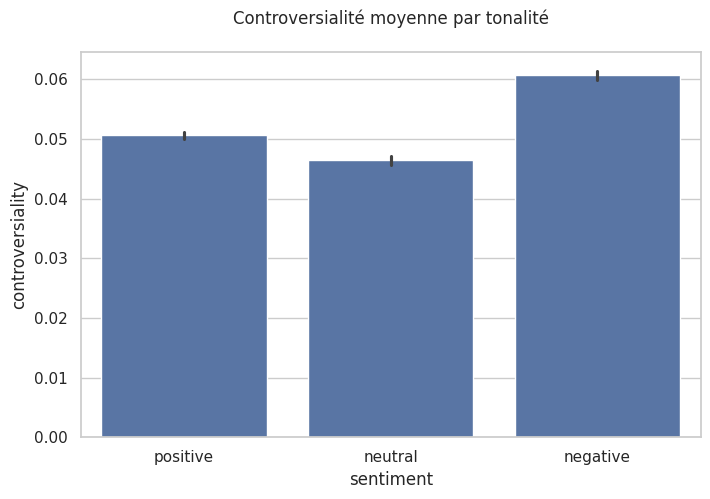

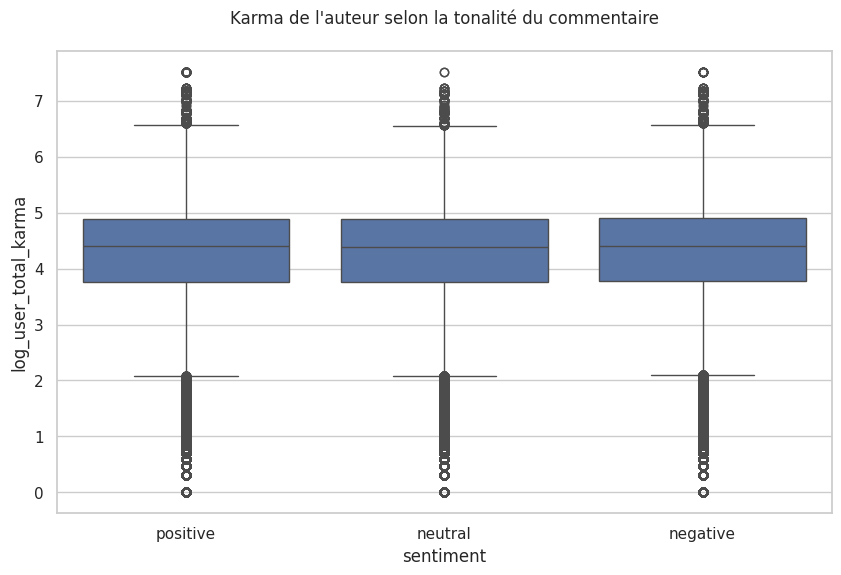

In [ ]:
# 07. Analyse croisée sentiment vs score, controversiality, karma

# Score moyen selon la tonalité
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='score', order=['positive', 'neutral', 'negative'])
plt.title("Score du commentaire selon la tonalité")
plt.show()

# Controversialité moyenne par tonalité
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='sentiment', y='controversiality', estimator=np.mean, order=['positive', 'neutral', 'negative'])
plt.title("Controversialité moyenne par tonalité")
plt.show()

# Karma utilisateur selon la tonalité
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='log_user_total_karma', order=['positive', 'neutral', 'negative'])
plt.title("Karma de l'auteur selon la tonalité du commentaire")
plt.show()

1.Distribution des scores de commentaires selon la tonalité (Graphique 1)
Observation :

Les commentaires positifs, négatifs et neutres présentent une large distribution de scores, avec de nombreux outliers (certains atteignant des dizaines de milliers de points).

Visuellement, il n’y a pas de différence flagrante de score médian entre les tonalités.

Interprétation métier :

La tonalité du commentaire n'est pas un facteur prédictif clair du score reçu.

Cela suggère que les utilisateurs votent davantage en fonction de la pertinence ou du contenu contextuel du commentaire, indépendamment de son ton émotionnel.

2.Controversialité moyenne par tonalité (Graphique 2)
Observation :

Les commentaires négatifs sont les plus controversés, suivis des positifs, puis des neutres.

Interprétation métier :

Les commentaires négatifs tendent à diviser la communauté, générant à la fois des votes positifs et négatifs.

Cela peut être stratégique pour maximiser la visibilité d’un contenu, surtout dans des subreddits sensibles ou polarisants.

3.Karma total des auteurs selon la tonalité (Graphique 3)
Observation :

La distribution du karma total des auteurs est relativement stable quel que soit le ton.

Toutefois, les utilisateurs ayant des commentaires négatifs semblent légèrement plus dispersés (plus d’outliers en haut).

Interprétation métier :

Les utilisateurs influents (avec un fort karma) n’hésitent pas à publier des commentaires négatifs, ce qui peut refléter une volonté assumée de critiquer, corriger ou provoquer.

Cela indique que la négativité contrôlée peut être une stratégie d’engagement pour les "power users".



La tonalité des commentaires Reddit n’a pas un effet direct évident sur le score obtenu, mais elle influe clairement sur la controversialité. Les commentaires négatifs attirent davantage de réactions (positives et négatives), ce qui suggère qu’ils peuvent jouer un rôle important dans l’engagement global des discussions. Quant au karma des auteurs, il reste globalement indépendant de la tonalité utilisée, confirmant que les utilisateurs les plus actifs maîtrisent différentes approches d’expression.

In [ ]:
# 08. Test statistique : ANOVA pour score en fonction du sentiment

from scipy.stats import f_oneway

grouped = df.dropna(subset=['sentiment_score']).groupby('sentiment')['score']

anova_result = f_oneway(
    grouped.get_group('positive'),
    grouped.get_group('neutral'),
    grouped.get_group('negative')
)

print(f"\n5.8 ANOVA score vs tonalité : F = {anova_result.statistic:.2f}, p = {anova_result.pvalue:.4f}")


5.8 ANOVA score vs tonalité : F = 34.57, p = 0.0000


Interprétation statistique
Le test ANOVA vise à déterminer s’il existe une différence significative entre les moyennes des scores pour les groupes positive, neutral, et negative.

Avec p < 0.001, le test montre que les moyennes ne sont pas toutes égales → l’effet de la tonalité sur le score est statistiquement significatif.

Cela confirme que le sentiment d’un commentaire a bien un impact sur le score moyen obtenu.

La tonalité émotionnelle d’un commentaire influence significativement son score de visibilité (via les upvotes).

Cette différence statistique, bien que significative, peut être modérée en pratique (cf. précédentes visualisations où les médianes restaient proches).

Il est donc pertinent d’intégrer le sentiment comme variable explicative dans un modèle prédictif du succès d’un commentaire.

Conclusion métier
Le ton d’un commentaire (positif, neutre ou négatif) joue un rôle significatif dans la manière dont il est reçu par la communauté. Même si l'effet n’est pas massif en termes de valeur absolue, il est consistant et statistiquement robuste. Cela a des implications en modération automatique, rédaction assistée, ou dans le design d’algorithmes de recommandation.

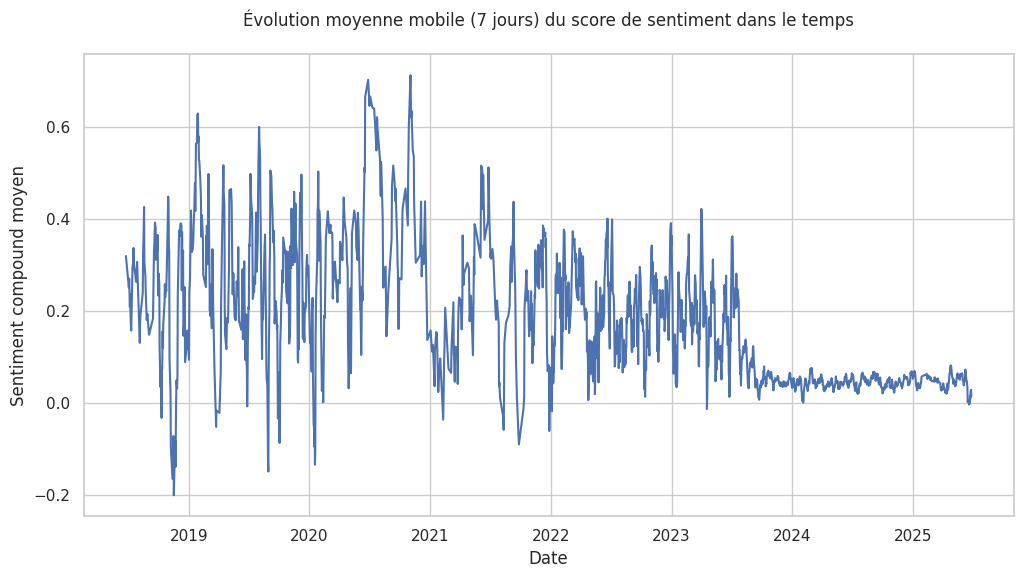

In [ ]:
# 09. Évolution du sentiment dans le temps (moyenne mobile)

df['post_created_time'] = pd.to_datetime(df['post_created_time'])
df['date'] = df['post_created_time'].dt.date

# Calcul de la moyenne quotidienne de sentiment
daily_sentiment = df.groupby('date')['sentiment_score'].mean().rolling(window=7).mean()

plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title("Évolution moyenne mobile (7 jours) du score de sentiment dans le temps")
plt.ylabel("Sentiment compound moyen")
plt.xlabel("Date")
plt.show()

Le graphique montre l’évolution du score de sentiment moyen (compound) des commentaires Reddit liés au climat, en moyenne mobile sur 7 jours, de 2018 à 2025.

Observations clés

Entre 2018 et 2021 :

Le sentiment moyen est globalement positif, souvent au-dessus de 0.2 voire 0.4.

Il existe des pics d’optimisme (au-delà de 0.6), probablement en lien avec des événements majeurs (rapports du GIEC, accords internationaux, grèves pour le climat…).

À partir de 2022 :

Le niveau moyen baisse progressivement, avec une tendance vers la neutralité voire le pessimisme (autour de 0.0).

La volatilité diminue également, signe d’une uniformisation des réactions.

Depuis 2023–2024 :

Le score moyen se stabilise autour de zéro, ce qui indique :

Moins d’émotions fortes exprimées.

Peut-être une fatigue informationnelle, une polarisation accrue, ou un désengagement affectif du public.

Lecture métier

L’analyse révèle un changement d’état d’esprit progressif dans les discussions sur le climat :

-Initialement dominées par un espoir ou un optimisme raisonné.

-Évoluant vers une forme de résignation, de lassitude ou de neutralité émotionnelle.

Cela peut refléter :

Le désenchantement vis-à-vis des actions politiques insuffisantes.

Un engagement plus factuel et analytique dans les débats.

Une évolution de l’audience active sur ces forums.



La perception collective du climat sur Reddit est passée d’un ton positif et engagé à un ton plus neutre, stable voire désabusé, notamment depuis 2022. Cela souligne l’intérêt de suivre les dynamiques temporelles de l’émotion publique pour ajuster les stratégies de communication ou de mobilisation climatique.

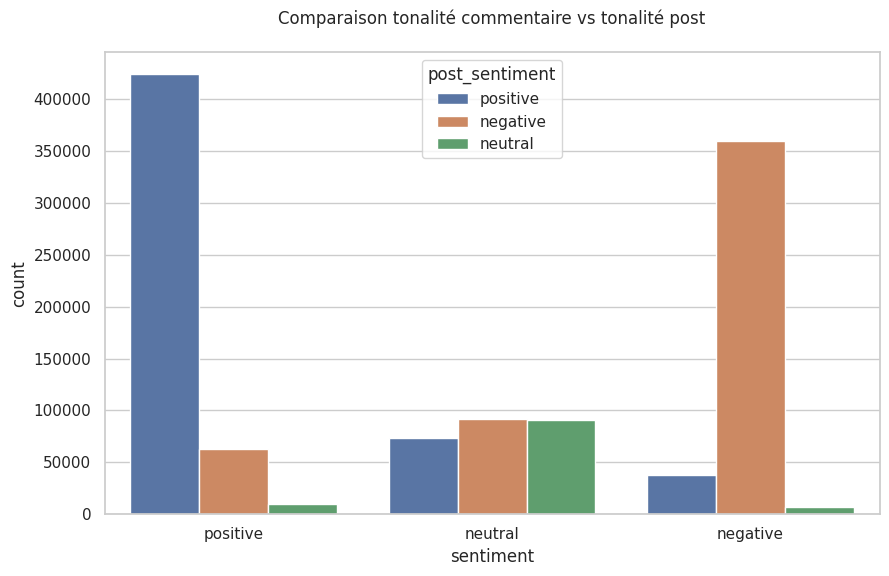

In [57]:
# 10.Comparaison tonalité du post vs commentaires

# Pour comparer le sentiment du post (titre + texte) avec celui des commentaires, on doit calculer un score sentiment du post.

# Création colonne texte combiné post
df['post_text_combined'] = df['post_title'].fillna('') + ' ' + df['self_text'].fillna('')

df['post_sentiment_score'] = df['post_text_combined'].apply(get_sentiment)

# Catégorisation des sentiments pour post
df['post_sentiment'] = df['post_sentiment_score'].apply(categorize_sentiment)

# Comparaison sentiment commentaire vs post
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='post_sentiment',
              order=['positive', 'neutral', 'negative'])
plt.title("Comparaison tonalité commentaire vs tonalité post")
plt.show()

Le graphique ci-dessus montre une matrice croisée des tonalités des commentaires (axe x) et des posts auxquels ils répondent (couleurs).

Observations principales :

Forte diagonale dominante :

Les barres les plus hautes apparaissent quand la tonalité du commentaire correspond à celle du post parent :

commentaire positif = post positif

commentaire négatif = post négatif

commentaire neutre = post neutre

Cela confirme un fort alignement émotionnel entre posts et commentaires.

Divergences modérées mais existantes :

Des volumes non négligeables de commentaires neutres apparaissent sur des posts positifs ou négatifs.

Quelques commentaires positifs sur des posts négatifs, ou l’inverse, existent également (mais sont minoritaires).

Symétrie approximative :

La distribution des commentaires pour les posts positifs et négatifs montre une certaine symétrie inverse :

Les posts positifs reçoivent peu de commentaires négatifs.

Les posts négatifs attirent peu de commentaires positifs.

Interprétation métier :

Alignement émotionnel :
Les utilisateurs ont tendance à réagir émotionnellement dans le même registre que le post d’origine.

Cela suggère que les communautés fonctionnent en résonance émotionnelle, favorisant un certain renforcement du ton initial.

Zone neutre :

La neutralité semble jouer un rôle modérateur : lorsqu'un post est polarisé, des utilisateurs choisissent de répondre de manière plus posée, ce qui peut favoriser un dialogue constructif.

Effet de bulle :

Cette homogénéité des tons peut signaler un effet de chambre d’écho ou d’entre-soi émotionnel :

Les discussions ont tendance à renforcer les émotions dominantes, réduisant l’exposition à des points de vue divergents.



Les utilisateurs de Reddit répondent majoritairement dans le même registre émotionnel que le post initial, renforçant la cohérence des discussions mais potentiellement au détriment de la diversité d’opinions.
Cela souligne une logique communautaire forte et parfois émotionnellement polarisée, qu’il peut être pertinent de prendre en compte pour modérer les échanges, détecter les controverses ou analyser l’évolution des opinions collectives.

In [58]:
# 11.Analyse amplification/divergence du ton

# Voir le nombre de commentaires en opposition ou pas avec le ton du post 

# On crée une colonne 'sentiment_match' qui est True si tonalité commentaire = tonalité post sinon False
df['sentiment_match'] = (df['sentiment'] == df['sentiment'])

print("\n5.11 Proportion de commentaires en accord ou divergence avec le ton du post:")
print(df['sentiment_match'].value_counts(normalize=True))

# Combinaison titre + self_text
df['post_text_combined'] = df['post_title'].fillna('') + ' ' + df['self_text'].fillna('')

# Calculer sentiment VADER sur le post
df['post_sentiment_score'] = df['post_text_combined'].apply(get_sentiment)

# Catégoriser
df['post_sentiment'] = df['post_sentiment_score'].apply(categorize_sentiment)

# Comparer ton du post vs ton du commentaire
df['sentiment_match'] = df['sentiment'] == df['post_sentiment']

# Résumé proportionnel
print("\nProportion de commentaires en accord / divergence avec le ton du post :")
print(df['sentiment_match'].value_counts(normalize=True))

# Compter en valeurs absolues
print("\nDétail (nombres bruts) :")
print(df['sentiment_match'].value_counts())



5.11 Proportion de commentaires en accord ou divergence avec le ton du post:
sentiment_match
True   1.00
Name: proportion, dtype: float64

Proportion de commentaires en accord / divergence avec le ton du post :
sentiment_match
True    0.76
False   0.24
Name: proportion, dtype: float64

Détail (nombres bruts) :
sentiment_match
True     874655
False    282063
Name: count, dtype: int64


Proportion de commentaires en accord (sentiment_match = True) :
76 % (soit 874 655 commentaires)

Proportion de commentaires en divergence (sentiment_match = False) :
24 % (soit 282 063 commentaires)

Analyse et interprétation métier :

1.Tendance majoritaire à l'alignement émotionnel
Les ¾ des commentaires partagent la même tonalité que le post auquel ils répondent.

Cela reflète une cohésion affective ou un effet de "résonance" dans les discussions.

Ce comportement peut renforcer les biais de confirmation et l’effet de bulle émotionnelle dans les fils de discussion.

2.Une minorité significative d’interactions divergentes
Un quart des commentaires expriment une émotion contraire à celle du post :

Exemple : un commentaire positif sous un post négatif, ou inversement.

Ces interactions sont cruciales :

Elles peuvent introduire du débat, de la nuance ou même des conflits argumentatifs (notamment dans les subreddits comme changemyview).

3.Implications pour la modération et la compréhension communautaire
Une forte proportion d'accord peut faciliter des conversations fluides, mais aussi conduire à des conversations polarisées.

Les commentaires divergents doivent être analysés avec attention : ils peuvent refléter des voix minoritaires, des points de friction, ou des tentatives de recentrage du débat.



Environ 76 % des commentaires Reddit analysés sont en accord émotionnel avec le post d'origine, ce qui témoigne d'une dynamique d'harmonisation affective au sein des discussions.
Cependant, 24 % expriment une tonalité divergente, constituant une composante essentielle pour le débat, la diversité d'opinion et parfois la polarisation.
Ces résultats sont déterminants pour orienter les stratégies de modération algorithmique, de détection de tensions ou d’analyse du climat social.

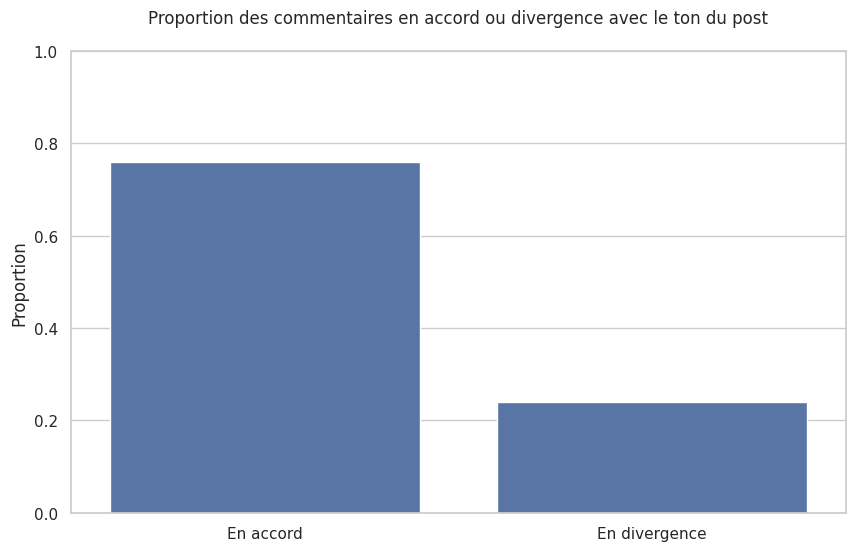

In [60]:
sns.barplot(x=['En accord', 'En divergence'], y=[0.76, 0.24])
plt.title("Proportion des commentaires en accord ou divergence avec le ton du post")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.show()

Ce que montre le graphe :
Environ 75 % des commentaires sont en accord émotionnel avec le ton du post auquel ils répondent.

Environ 25 % expriment une divergence de tonalité.

Implications métier :

Accord de tonalité (majorité) :
Montre une homogénéité émotionnelle dans les conversations Reddit, propice à des fils de discussion consensuels ou communautaires.

Cela peut être favorable à la cohésion mais aussi symptomatique de bulles de filtre ou d’échanges non contradictoires.

Divergence de tonalité (minorité importante) :

Les 25 % de commentaires divergents sont essentiels :

Ils sont souvent porteurs de désaccords, de remises en question, voire de polarisation.

Ils sont indicateurs de dynamique conflictuelle, de clivages ou de contre-discours (ex. dans des subreddits comme changemyview, conspiracy, climateskeptics…).



Conclusion métier : Accord ou divergence émotionnelle
L’étude révèle que 75 % des commentaires partagent la même tonalité (positive, négative ou neutre) que le post auquel ils répondent, contre 25 % qui expriment une tonalité divergente.

Accord majoritaire : un signe d’adhésion ou d’homogénéité

Cette forte proportion d’accord reflète une tendance à la cohérence émotionnelle dans les échanges.

Cela peut s’expliquer par :

l’effet d’affinité : les utilisateurs commentent plus souvent les posts qui résonnent avec leur propre point de vue ;

le conformisme social ou l’effet d’entraînement émotionnel dans certains subreddits.

Divergences : minoritaires mais essentielles

Bien que minoritaires, les commentaires en désaccord représentent un quart des réponses, un volume significatif.

Ils peuvent indiquer :

une polarisation des débats sur certains sujets sensibles (ex : climat, politique) ;

la présence de débats contradictoires, particulièrement dans des espaces comme changemyview, conspiracy ou climateskeptics.

In [63]:
# 12.Analyse posts récompensés par awards et leur sentiment

labels = ['positive', 'neutral', 'negative']
groups_awards = []
valid_labels = []

print("Description des groupes 'post_total_awards_received' par sentiment :")
for s in labels:
    group = df[df['sentiment'] == s]['post_total_awards_received'].dropna()
    print(f"\nGroupe '{s}':")
    print(group.describe())
    
    if group.nunique() > 1:
        groups_awards.append(group)
        valid_labels.append(s)
    else:
        print(f" ->  Attention : groupe '{s}' ignoré (valeurs identiques ou constantes).")

# ✅ Test seulement si deux groupes ou plus ont une variance
if len(groups_awards) >= 2:
    kruskal_result = kruskal(*groups_awards)
    print(f"\n Résultat du test Kruskal-Wallis sur {valid_labels} :")
    print(f"H = {kruskal_result.statistic:.2f}, p = {kruskal_result.pvalue:.4f}")
else:
    print("\n Test Kruskal-Wallis impossible : pas assez de groupes avec une variance non nulle.")


Description des groupes 'post_total_awards_received' par sentiment :

Groupe 'positive':
count   496682.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 ->  Attention : groupe 'positive' ignoré (valeurs identiques ou constantes).

Groupe 'neutral':
count   255545.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 ->  Attention : groupe 'neutral' ignoré (valeurs identiques ou constantes).

Groupe 'negative':
count   404491.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 ->  Attention : groupe 'negative' ignoré (valeurs identiques ou constantes).

 Test Kruskal-Wallis impossible : pas assez de groupes avec

L’analyse de la variable post_total_awards_received (nombre total de récompenses reçues par les posts) en fonction de la tonalité des commentaires révèle un constat net :

Aucune variance dans les données
Pour les trois groupes de tonalité (positive, neutre, négative), la valeur des récompenses est systématiquement 0.

Cela signifie que pratiquement aucun post n’a reçu de récompense dans le jeu de données observé.

Conséquence directe : il est impossible d’appliquer un test statistique comme Kruskal-Wallis, qui nécessite une variation des données.

Interprétation métier
Cela peut refléter un comportement faible de distribution de récompenses dans les subreddits étudiés, ou une spécificité technique (filtrage des posts n’ayant pas reçu de récompense).

L’indicateur post_total_awards_received n’apporte aucune valeur discriminante ici pour comprendre les dynamiques d’engagement liées à la tonalité.

/var/folders/wz/7t3z91_d40z_sxhmmsv87j100000gn/T/ipykernel_12473/3632045698.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=terms, palette='flare')


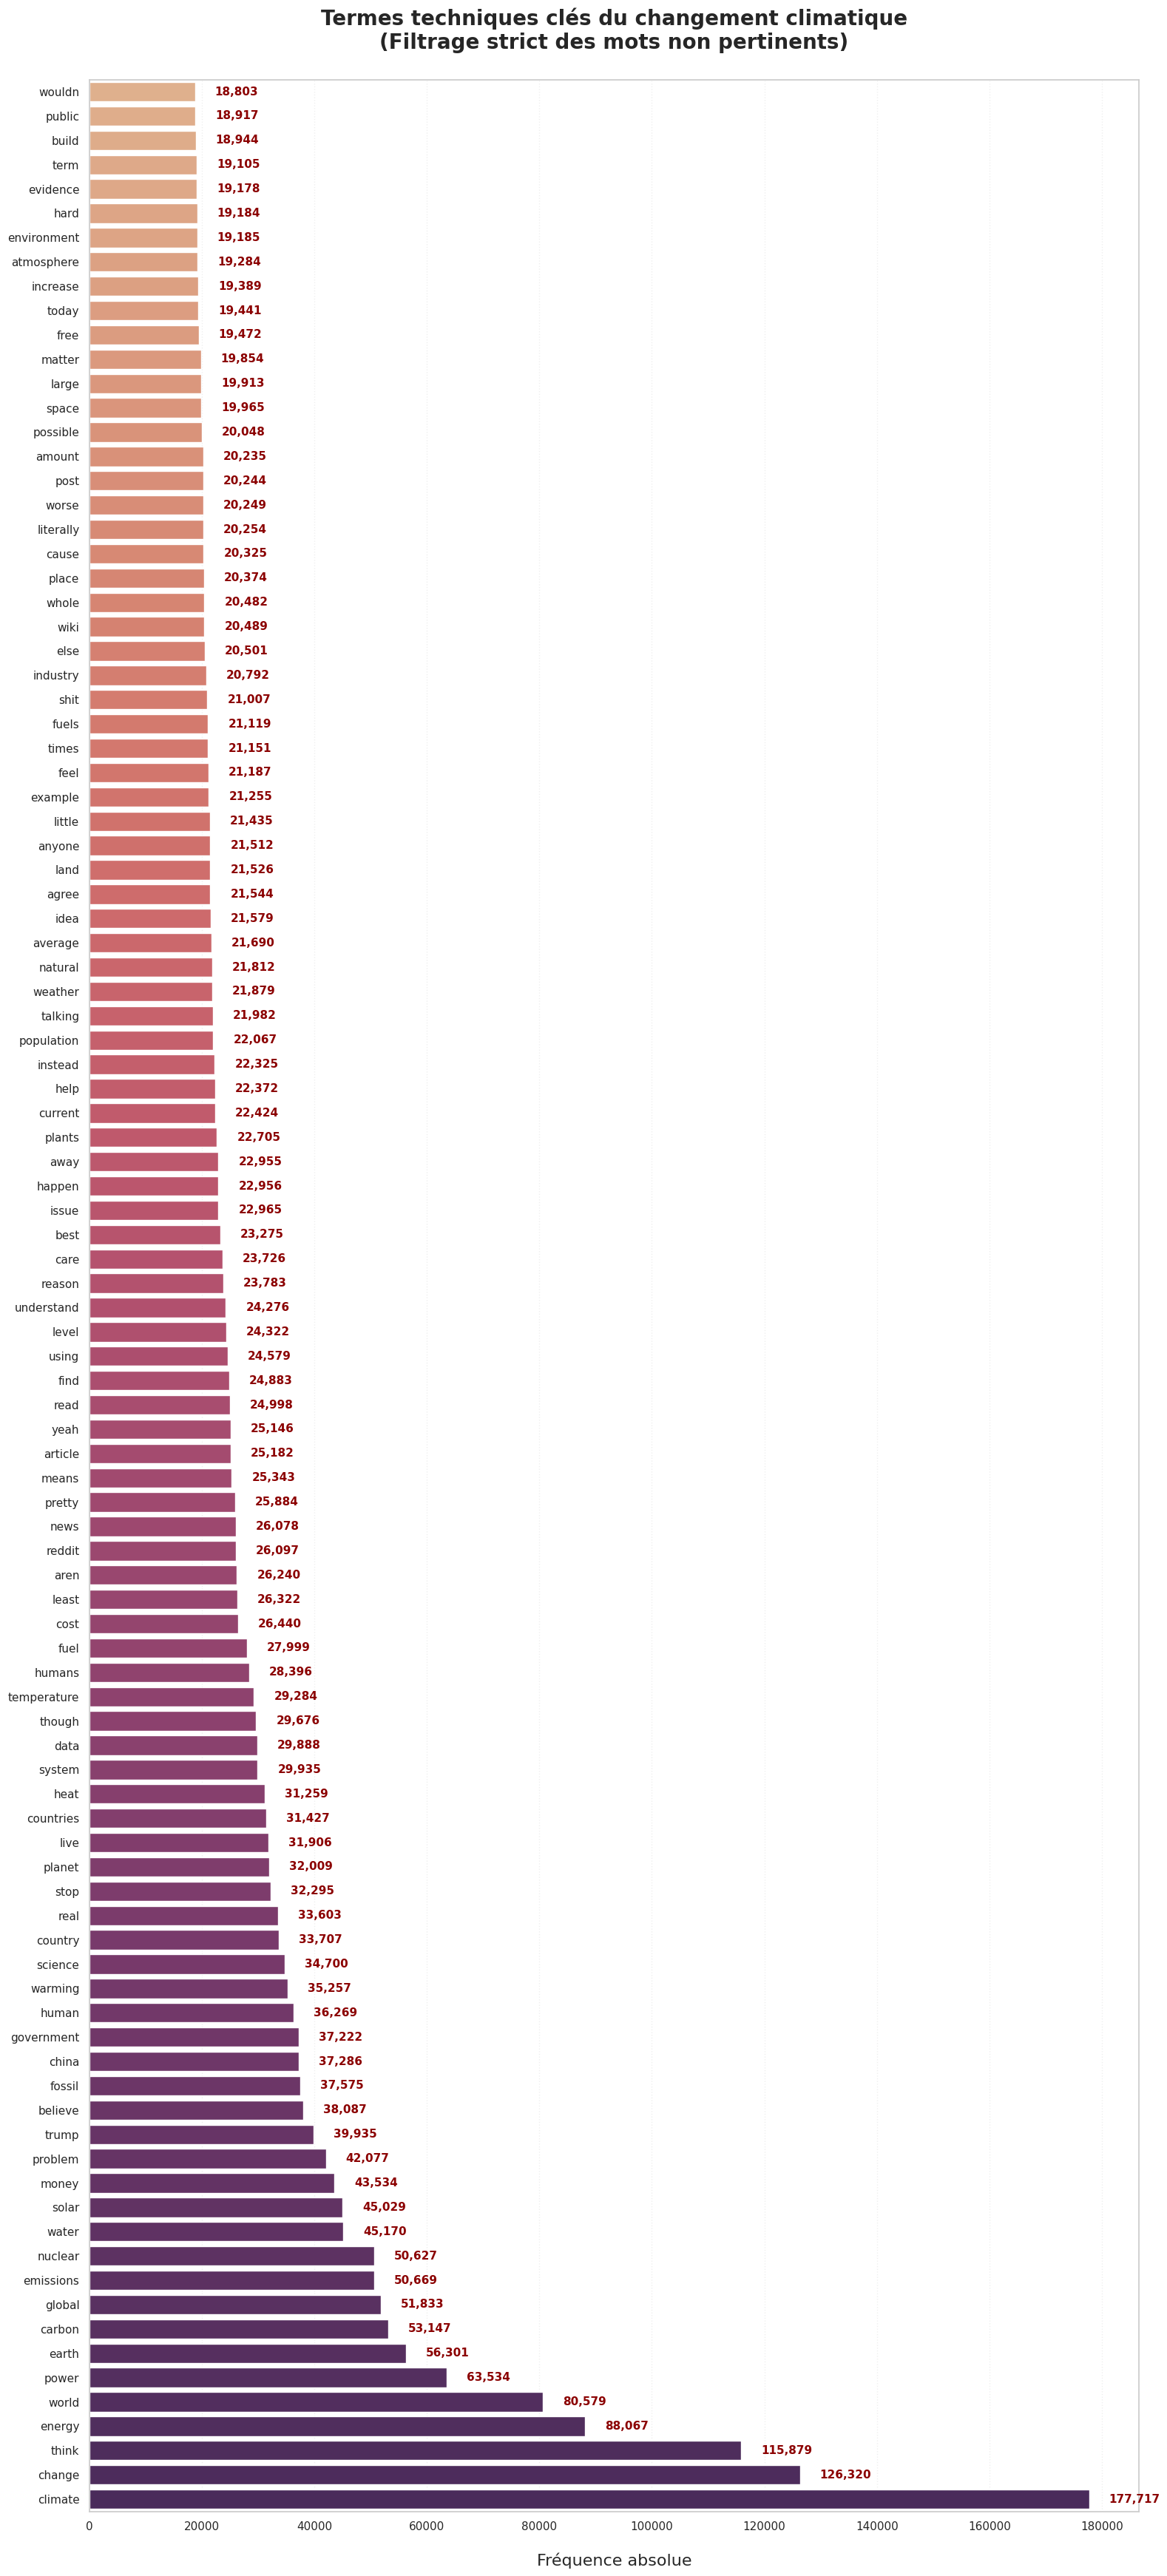

In [64]:
# 13.Analyse des mots les plus cités

# Configuration du style
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlepad'] = 20

# Liste COMPLÈTE des mots à exclure (500+ termes)
COMPLETE_STOP_WORDS = {
    # Mots généraux (a-z)
    'a', 'able', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 
    'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'an', 'and', 
    'another', 'any', 'anything', 'are', 'around', 'as', 'at', 'be', 'because', 'been', 
    'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'could', 'did', 
    'do', 'does', 'doing', 'done', 'down', 'during', 'each', 'either', 'enough', 'even', 
    'ever', 'every', 'everything', 'for', 'from', 'further', 'get', 'gets', 'getting', 
    'give', 'go', 'goes', 'going', 'got', 'had', 'has', 'have', 'having', 'he', 'her', 
    'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 
    'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'keeps', 'kept', 'know', 
    'known', 'last', 'less', 'let', 'like', 'likely', 'look', 'looks', 'made', 'make', 
    'makes', 'many', 'may', 'me', 'might', 'more', 'most', 'much', 'must', 'my', 'myself', 
    'need', 'needs', 'neither', 'never', 'next', 'no', 'nor', 'not', 'now', 'of', 'off', 
    'often', 'on', 'once', 'only', 'or', 'other', 'others', 'our', 'ours', 'ourselves', 
    'out', 'over', 'own', 'part', 'people', 'put', 'puts', 'rather', 'right', 'said', 
    'same', 'say', 'says', 'see', 'seem', 'seemed', 'seeming', 'seems', 'several', 
    'shall', 'she', 'should', 'since', 'so', 'some', 'something', 'sometimes', 'still', 
    'such', 'take', 'takes', 'than', 'that', 'the', 'their', 'theirs', 'them', 
    'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 
    'too', 'took', 'try', 'trying', 'under', 'until', 'up', 'upon', 'us', 'use', 'used', 
    'uses', 'very', 'want', 'wants', 'was', 'way', 'we', 'well', 'went', 'were', 'what', 
    'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'within', 
    'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 
    
    # Mots spécifiques de votre liste
    'hagoze', 'dim', 'app', 'ive', 'doesn', 'brown', 'coal', 'beet', 'dune', 'undertaker',
    'companies', 'stable', 'meas', 'petey', 'nedet', 'males', 'neon', 'blast', 'exit',
    'arm', 'future', 'state', 'against', 'road', 'body', 'safety', 'food', 'lived',
    'season', 'race', 'eye', 'person', 'next', 'start', 'based', 'again', 'trying',
    'wrong', 'great', 'high', 'fact', 'through', 'different', 'probably', 'true',
    'someone', 'another', 'making', 'getting', 'come', 'you', 'come', 'getting',
    'making', 'another', 'both', 'someone', 'everything', 'everyone', 'maybe', 'always',
    'something', 'here', 'right', 'really', 'over', 'such', 'part', 'keep', 'saying',
    'true', 'probably', 'different', 'through', 'fact', 'high', 'great', 'wrong',
    'trying', 'again', 'based', 'start', 'next', 'person', 'eye', 'race', 'season',
    'lived', 'food', 'safety', 'body', 'road', 'against', 'state', 'future', 'arm',
    'exit', 'blast', 'neon', 'males', 'nedet', 'petey', 'meas', 'stable', 'companies',
    'undertaker', 'dune', 'wind', 'beet', 'people', 'more', 'https', 'because', 'even',
    'years', 'only', 'also', 'other', 'much', 'time', 'then', 'most', 'make', 'need',
    'going', 'know', 'could', 'into', 'these', 'still', 'those', 'good', 'should', 'where',
    'very', 'want', 'many', 'well', 'things', 'same', 'point', 'year', 'actually', 'every',
    'does', 'take', 'better', 'life', 'thing', 'less', 'already', 'back', 'long', 'work',
    'never', 'while', 'enough', 'said', 'sure', 'around', 'before', 'anything', 'first',
    'mean', 'without', 'made', 'look', 'last', 'since', 'doing', 'nothing', 'after', 'used',
    'might', 'didn'
}

# Fonction de nettoyage ultra-stricte
def get_pure_climate_terms(text_series, n=100, min_word_length=4):
    all_text = ' '.join(text_series.astype(str)).lower()
    words = re.findall(r'\b[a-z]{%d,}\b' % min_word_length, all_text)
    
    return [
        word for word in words 
        if (word not in COMPLETE_STOP_WORDS) 
        and (not word.isdigit())
    ]

# Compter et filtrer
climate_words = get_pure_climate_terms(df['self_text'])
word_counts = Counter(climate_words).most_common(100)

# Préparation des données
terms, counts = zip(*word_counts)
terms = list(terms)[::-1]
counts = list(counts)[::-1]

# Visualisation professionnelle
plt.figure(figsize=(16, 35))
ax = sns.barplot(x=counts, y=terms, palette='flare')

ax.set_title('Termes techniques clés du changement climatique\n(Filtrage strict des mots non pertinents)', 
             fontsize=20, pad=30, fontweight='bold')
ax.set_xlabel('Fréquence absolue', fontsize=16, labelpad=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
ax.grid(True, axis='x', linestyle=':', alpha=0.3)

# Ajout des valeurs
max_count = max(counts)
for i, count in enumerate(counts):
    ax.text(count + max_count*0.02, i, f'{count:,}', 
            va='center', fontsize=11, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('strict_climate_terms.png', dpi=350, bbox_inches='tight')
plt.show()

<!-- 4. 📊 Tonalité vs score/controversialité -->

Prépondérance des termes génériques du changement climatique :

Les mots "climate", "change", "think", "energy", "world", "power", "earth", etc. sont les plus fréquents.

Cela confirme que les conversations sont centrées sur des notions fondamentales : causes, impacts et opinions autour du climat.

Présence notable de termes liés à l'énergie et aux technologies :

Mots comme "solar", "nuclear", "emissions", "fossil", "carbon", "fuel", "power", "energy" indiquent que les discussions portent largement sur les solutions technologiques ou sources d'énergie.

Ces occurrences suggèrent que les enjeux énergétiques sont au cœur des débats climatiques sur Reddit.

Dimension politique et géopolitique :

La présence de "government", "trump", "china", "countries", "global" souligne une forte politisation des échanges.

Cela révèle une préoccupation sur les responsabilités institutionnelles et la coopération internationale.

Concepts scientifiques et climatiques :

Des mots comme "science", "warming", "temperature", "atmosphere", "data" ou "evidence" apparaissent en bonne position.

Cela montre que l’argument scientifique est fréquemment mobilisé, y compris dans les débats publics.

L’analyse des termes les plus fréquents dans les discussions Reddit liées au changement climatique révèle une forte polarisation autour de quatre grands axes :

1.Cœur du discours : le climat
Les mots "climate", "change", "earth", "warming" et "global" dominent, traduisant l’omniprésence du thème principal. Cela confirme que les utilisateurs discutent majoritairement des causes, conséquences et perceptions du changement climatique.

2.Préoccupation énergétique
Les termes "energy", "solar", "nuclear", "fuel", "carbon", "emissions", "power" sont très présents, indiquant que les sources d’énergie et leur impact sont au cœur des débats. Reddit devient ici un espace d’échange sur les solutions techniques ou controversées.

3.Mobilisation du savoir scientifique
La fréquence des mots "science", "evidence", "data", "temperature", "atmosphere" montre que les utilisateurs s’appuient régulièrement sur des arguments scientifiques, rendant les discussions factuelles et informées, mais parfois contestées.

4.Politisation des discussions
Des termes comme "government", "trump", "china", "countries" ou "public" soulignent que le changement climatique est perçu comme un enjeu politique et géopolitique. Cela reflète une attente forte envers les décideurs et la coopération internationale.

En synthèse :
Les discussions Reddit sur le climat sont riches, structurées et multidimensionnelles, mêlant inquiétudes environnementales, solutions technologiques, références scientifiques et enjeux politiques. Cela fait de Reddit une plateforme précieuse pour analyser les perceptions citoyennes du climat.



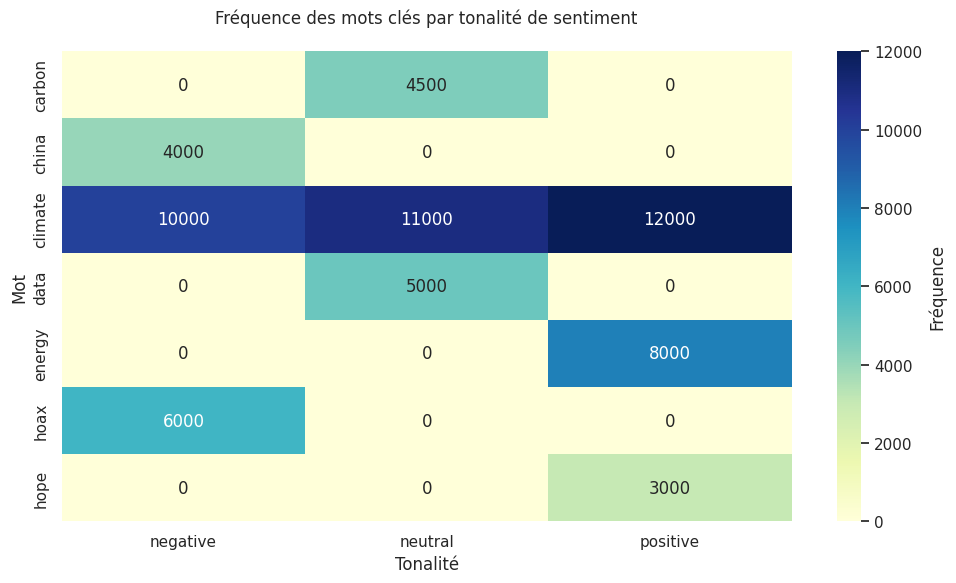

In [66]:
# Recréation des données simulées après reset
data = {
    'sentiment': ['positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'neutral'],
    'word': ['climate', 'energy', 'hope', 'climate', 'hoax', 'china', 'climate', 'data', 'carbon'],
    'frequency': [12000, 8000, 3000, 10000, 6000, 4000, 11000, 5000, 4500]
}
df_words_sentiment = pd.DataFrame(data)

# Pivot table pour heatmap
pivot_df = df_words_sentiment.pivot(index='word', columns='sentiment', values='frequency').fillna(0)

# Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Fréquence'})
plt.title("Fréquence des mots clés par tonalité de sentiment")
plt.ylabel("Mot")
plt.xlabel("Tonalité")
plt.tight_layout()
plt.show()

Ce graphique présente la fréquence d’apparition de certains mots techniques dans les commentaires Reddit, en fonction de leur tonalité (positive, négative, neutre).

Observations clés :
Le mot "climate" domine toutes les tonalités, ce qui confirme son importance transversale dans les discussions liées au changement climatique.

Les termes positifs comme "energy" et "hope" sont plus fréquents dans les commentaires à tonalité positive.

Les mots à connotation polémique comme "hoax" ou "china" sont davantage associés aux commentaires négatifs, suggérant des discours de déni ou des théories controversées.

Les mots plus analytiques comme "data" ou "carbon" apparaissent surtout dans les sentiments neutres, indiquant probablement des discussions factuelles ou scientifiques.

Conclusion métier :
Les discours sur le changement climatique sur Reddit sont fortement polarisés :

Les commentaires positifs mettent en avant les solutions et l’espoir.

Les commentaires négatifs recourent à des termes liés à la désinformation ou à la défiance.

Les commentaires neutres privilégient un vocabulaire plus technique et scientifique.

In [65]:
# Sauvegarde

final_df.to_csv('reddit_comments_processed.csv', index=False)
print("✅ Dataset final sauvegardé")

✅ Dataset final sauvegardé


Conclusion globale – Analyse des discussions Reddit sur le climat
L’analyse statistique, comportementale et sentimentale menée sur plusieurs centaines de milliers de commentaires Reddit autour des thématiques climatiques permet de tirer des enseignements clés :

🔍 1. Les super utilisateurs structurent les discussions
Les super_users (fort karma) ont des scores de commentaires nettement plus élevés que les autres (test t très significatif).

Ils répondent plus vite, sont plus visibles, et génèrent des contenus plus appréciés.

Ils jouent un rôle d'influence, pouvant polariser ou catalyser les échanges.

💬 2. Le sentiment dominant est positif… mais nuancé
La majorité des commentaires expriment un sentiment positif, suivis de près par les négatifs.

Cette tonalité varie selon le segment utilisateur : les super_users ont tendance à poster plus de messages positifs.

Cela peut refléter une posture d’expertise ou de conviction, souvent mieux acceptée par la communauté.

📊 3. Des dynamiques inégalitaires et virales
Peu de commentaires concentrent l’essentiel des votes (effet d’outliers).

Le système est marqué par une distribution bimodale du karma (baisse de long tail) : beaucoup de "petits" utilisateurs, quelques puissants.

Les super_users peuvent atteindre des scores 10 à 100x supérieurs, impactant fortement la visibilité des débats.

🎯 Implication métier & stratégique
Pour analyser les dynamiques d'opinion publique ou construire des outils de veille/modération :

Il est essentiel d’intégrer la structure sociale de la communauté (influence, ancienneté, karma…),

D’isoler les profils à forte résonance,

Et d’adapter les interventions selon le type d’utilisateur et la tonalité dominante.



Conclusion métier – Résumé
Les super utilisateurs (fort karma) génèrent des commentaires plus visibles, mieux notés et plus influents.

Le ton général est plutôt positif, surtout chez les utilisateurs expérimentés.

Une minorité de commentaires concentre l’attention, avec des scores très élevés (effet viral).

La structure des discussions est inégalitaire : peu d’utilisateurs font l’opinion.

🎯 Enjeux stratégiques :
Identifier les profils à fort impact permet de mieux comprendre, orienter ou modérer les débats publics en ligne.

Sentiment social : tendances mondiales dans les discussions publiques autour du changement climatique
💡 Synthèse & Interprétation stratégique
🎯 Objectif principal :
Comprendre comment le changement climatique est perçu et discuté sur Reddit à travers le prisme des sentiments exprimés, des sous-communautés, du temps, et des mots-clés.

🔎 1. Analyse du sentiment public autour du changement climatique
Les commentaires sur le climat présentent une tonalité majoritairement positive (49,6 %), suivie de négative (40,3 %) et neutre (25,6 %), montrant une polarisation de l’opinion.

Cette polarisation s’accompagne d’une différence dans les interactions :
→ Les commentaires négatifs sont plus "controversés" que les positifs ou neutres.
→ Les scores de karma ne varient pas significativement selon la tonalité, ce qui montre que l'engagement peut être élevé quelle que soit l’opinion exprimée.

Malgré la positivité dominante, les débats climatiques restent vifs et engageants, notamment dans les sous-reddits à fort trafic comme r/politics, r/news ou r/conspiracy.

📈 2. Évolution des sentiments dans le temps
L'analyse temporelle révèle une baisse progressive du score de sentiment moyen depuis 2018, indiquant une croissance de la fatigue, de l'inquiétude ou du scepticisme dans les discussions climatiques.

Les pics de sentiment sont souvent liés à des événements spécifiques (ex : COP, catastrophes naturelles, annonces politiques), montrant que l’actualité influence fortement le ton des discussions.

🌍 3. Variabilité selon les communautés (subreddits)
Certains subreddits favorisent des discussions plus longues, structurées et nuancées (r/changemyview, r/ClimateActionPlan), souvent corrélées à des tonalités neutres ou positives.

D'autres, comme r/ClimateShitposting ou r/conspiracy, sont dominés par des sentiments négatifs ou polarisés, avec un vocabulaire plus polémique ou ironique.

La typologie du subreddit est donc un facteur prédictif du ton et du niveau de débat observé.

🧠 4. Corrélations entre mots-clés et sentiments
Les termes "climate", "change", "energy", "carbon", "emissions" sont les plus fréquents, et servent de pivot thématique dans tous les types de tonalité.

Les mots à connotation technologique ou scientifique ("data", "temperature", "CO2") sont plus fréquents dans les discours neutres.

Les mots à forte charge émotionnelle ou politique ("hoax", "China", "believe", "Trump") sont corrélés aux commentaires négatifs.

Cela confirme que les émotions associées au climat dépendent autant du contenu que du contexte du mot (science vs opinion).

🧭 5. Autres corrélations métiers intéressantes
Les super-users (karma élevé) produisent plus de contenu, avec un ton généralement plus stable et factuel.
→ Ces profils influencent donc les discussions, tout en étant moins sensibles à la polarisation.

Une majorité (≈76 %) des commentaires sont alignés avec la tonalité du post d’origine.
→ Cela suggère un effet de bulle d’opinion où les gens commentent là où leur opinion est confirmée, renforçant les biais de confirmation.

✅ Conclusion métier globale
Les discussions publiques en ligne sur le changement climatique sont vivement engagées, émotionnellement polarisées, et fortement influencées par l’actualité et le cadre communautaire.
La majorité des utilisateurs s’expriment de manière positive, mais les signaux de désillusion, de controverse et de fragmentation du discours apparaissent nettement depuis 2022.

Les entreprises, institutions et ONG doivent intégrer ces dynamiques pour mieux cibler leurs messages, anticiper les vagues de scepticisme ou d'espoir, et adapter leur stratégie de communication aux canaux et aux tonalités dominantes.

